In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import numpy as np
import ase 
from ase.io import read
import json  
from ase.units import Hartree

In [3]:
torch.set_default_dtype(torch.float64) # set default dtype of torch to avoid numerical errors 

# Instantiate the Molecule Dataset 

In [4]:
device = "cpu"

In [5]:
from mlelec.data.dataset import MoleculeDataset

In [6]:
molecule_data = MoleculeDataset(
    mol_name = "ethane",
    use_precomputed=True,
    path= "examples/data/ethane",
    aux_path="examples/data/ethane/sto-3g",
    frame_slice=slice(0, 200),
    device=device,
    aux=["overlap", "orbitals"],
    target=["fock", "dipole_moment"],
)


Loading structures
examples/data/ethane/sto-3g/fock.hickle
examples/data/ethane/sto-3g/dipole_moment.hickle


In [7]:
from src.mlelec.utils.learning_utils import compute_batch_dipole_moment, compute_dipole_moment_from_mf, instantiate_mf, compute_dipole_moment

Using PyTorch backend.


### Create the ML dataset from the molecular data 

In [8]:
from mlelec.data.dataset import MLDataset

In [9]:
ml_data = MLDataset(
    molecule_data=molecule_data,
    device=device,
    model_strategy="coupled",
    shuffle=True, 
    shuffle_seed=5380,
)  

In [10]:
ml_data._split_indices(train_frac=0.7, val_frac=0.2, test_frac=0.1)

In [11]:
all_mfs, fockvars = instantiate_mf(
        ml_data,
        fock_predictions = molecule_data.target['fock'],
        batch_indices = list(range(len(ml_data.structures))),
    )


In [12]:
from mlelec.features.acdc import compute_features_for_target
from mlelec.data.dataset import get_dataloader

In [13]:
hypers = {
            "cutoff": 5.0,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }

ml_data._set_features(compute_features_for_target(ml_data, device = device, hypers = hypers))

In [14]:
train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="tensor", batch_size=10)

# RidgeCV Model

In [15]:
from src.mlelec.models.linear import LinearTargetModel

### Fitting a RidgeCV model

In [16]:
model = LinearTargetModel(dataset = ml_data, nlayers = 1, nhidden = 16, bias = False, device = device)

In [17]:
pred_ridges, ridges = model.fit_ridge_analytical(alpha = np.logspace(-8, -1, 12), cv=3, set_bias=False)

### Calculating train and test errors for MO energies and dipoles

In [18]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, _to_matrix, unfix_orbital_order
    
uncoupled = _to_uncoupled_basis(pred_ridges,  device=model.device) # Convert the coupled blocks to uncoupled

# Recover the predicted matrices for the training set 
fock_predictions_train = _to_matrix(
    uncoupled,
    ml_data.train_frames,
    ml_data.aux_data['orbitals'],
    device=model.device,
)

In [19]:
from typing import Optional, List, Union, Tuple, Dict

def isqrtm(A: torch.Tensor) -> torch.Tensor:
    eva, eve = torch.linalg.eigh(A)
    idx = eva > 1e-15
    return eve[:, idx] @ torch.diag(eva[idx] ** (-0.5)) @ eve[:, idx].T

def isqrtp(A: torch.Tensor) -> torch.Tensor:
    eva, eve = torch.linalg.eigh(A)
    idx = eva > 1e-15
    return eve[:, idx] @ torch.diag(eva[idx] ** (0.5)) @ eve[:, idx].T


def _lowdin_orthogonalize(
    fock: torch.Tensor, ovlp: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    ovlp_i12 = isqrtm(ovlp)
    return torch.einsum("ij,jk,kl->il", ovlp_i12, fock, ovlp_i12)

In [20]:
# from mlelec.utils.twocenter_utils import _lowdin_orthogonalize

def compute_eigvals(ml_data, focks, indices):
    batch_frames = [ml_data.structures[i] for i in indices]
    batch_fock = unfix_orbital_order(
        focks, batch_frames, ml_data.molecule_data.aux_data["orbitals"]
    )
    batch_overlap = ml_data.molecule_data.aux_data["overlap"][indices]
    ortho_focks = [_lowdin_orthogonalize(f, o) for f, o in zip(batch_fock, batch_overlap)]
    eva = []
    for i in range(len(focks)):
        eva.append(torch.linalg.eigvalsh(ortho_focks[i]))
    return torch.stack(eva)

In [21]:
H = ml_data.molecule_data.target["fock"][0]
S = ml_data.molecule_data.aux_data["overlap"][0]

In [22]:
from xitorch.linalg import symeig
import xitorch
Hx = xitorch.LinearOperator.m(H)
Sx = xitorch.LinearOperator.m(S)
eval, mo_coeff = symeig(Hx, M = Sx)

In [23]:
from scipy.linalg import sqrtm

In [24]:
def compute_mulliken(ml_data, focks, indices):
    # We access the basis written as a dictionary from ml_data
    basis = ml_data.molecule_data.aux_data['orbitals']
    # We access the ase frames for each structure in the batch
    batch_frames = [ml_data.structures[i] for i in indices]
    # We access the Fock matrices for each structure in the batch
    batch_fock = unfix_orbital_order(
        focks, batch_frames, ml_data.molecule_data.aux_data["orbitals"]
    )
    # We access the overlap matrices for each structure in the batch
    batch_overlap = ml_data.molecule_data.aux_data["overlap"][indices] 
    
    #ortho_focks = [_lowdin_orthogonalize(f, o) for f, o in zip(batch_fock, batch_overlap)]
    # S_sqrt = []
    eva = []
    rho_list = []
    pop = []
    density_matrices = []
    for a in range(len(focks)):
        
        Hx = xitorch.LinearOperator.m(batch_fock[a])
        Sx = xitorch.LinearOperator.m(batch_overlap[a])
        eval, mo_coeff = symeig(Hx, M = Sx)
        #eval, mo_coeff = torch.linalg.eigh(ortho_focks[a])
        
        eva.append(eval)
        frame = batch_frames[a]
        S_sqrt = isqrtp(batch_overlap[a])
        # Define the single particle density matrix
        half_nelec = frame.numbers.sum() // 2
        mo_occ = torch.zeros(mo_coeff.shape[1])
        mo_occ[:half_nelec] = 2
        mocc = mo_coeff[:,mo_occ>0]
        dm = (mocc*mo_occ[mo_occ>0]) @ (mocc.conj().T)
        
        natm = len(frame)
        # rho = torch.zeros((len(indices), natm, natm))
        # for i in range(len(indices)):
        rho = S_sqrt @ dm @ S_sqrt
        rho_list.append(rho)
        density_matrices.append(dm)
        P = []
        d = torch.zeros((natm, natm))
        for i in range(natm):
            i_start = int(np.sum([len(basis[s]) for s in frame.numbers[0:i]]))
            i_end = i_start + len(basis[frame.numbers[i]])
            for j in range(natm):
                j_start = int(np.sum([len(basis[s]) for s in frame.numbers[0:j]]))
                j_end = j_start + len(basis[frame.numbers[j]])
                d[i, j] = torch.sum(dm[i_start:i_end, j_start:j_end])
            #x = rho[i_start:i_end, i_start:i_end]
            #P_uu = torch.trace(x)
            #P.append(P_uu)
        #pop.append(P)
        P.append(d)
                # rho[i,j] = torch.sum(S_sqrt[a] @ dm[i_start:i_end, j_start:j_end] @ S_sqrt[a])
        
    return torch.stack(eva), torch.stack(rho_list), torch.stack(P), torch.stack(density_matrices)

In [25]:
# f = ml_data.molecule_data.target['fock'][0]
# s = ml_data.aux_data['overlap'][0]
# orbs = ml_data.aux_data['orbitals']
# frame = ml_data.structures[0]

In [26]:
# Hx = xitorch.LinearOperator.m(f)
# Sx = xitorch.LinearOperator.m(s)
# eval, mo_coeff = symeig(Hx, M = Sx)
# #eval, mo_coeff = torch.linalg.eigh(ortho_focks[a])

# # Define the single particle density matrix
# half_nelec = frame.numbers.sum() // 2
# mo_occ = torch.zeros(mo_coeff.shape[1])
# mo_occ[:half_nelec] = 2
# mocc = mo_coeff[:,mo_occ>0]
# dm = (mocc*mo_occ[mo_occ>0]) @ (mocc.conj().T)
# rho = isqrtp(s) @ dm @ isqrtp(s)

# P = []
# for i in range(8):
#     i_start = int(np.sum([len(orbs[s]) for s in frame.numbers[0:i]]))
#     i_end = i_start + len(orbs[frame.numbers[i]])
#     x = rho[i_start:i_end, i_start:i_end]
#     P_uu = torch.trace(x)
#     P.append(P_uu)

In [27]:
# fock_tilde = _lowdin_orthogonalize(f, s)
# eps, c_tilde = torch.linalg.eigh(fock_tilde)

# nmo = f.shape[-1]
# n_elec = frame.numbers.sum()

# mo_occ = _get_mo_occ(nmo, n_elec)
# occidx = _get_occidx(mo_occ)
# dm = 2*c_tilde[:, occidx] @ c_tilde[:, occidx].conj().T

# pop = 2 * torch.einsum("ia,ia->i", c_tilde[:, occidx], c_tilde[:, occidx].conj())

In [25]:
def lowdin(frames, dm):
    charges = []
    for i, f in enumerate(frames):
        z = f.get_atomic_numbers()
        chg = z - dm[i]
        charges.append(chg)
    return np.array(charges)

In [29]:
# P , [sum([1.9853, 1.0098, 1.0094, 1.0331, 1.0431]), sum([1.9852, 1.0145, 1.0048, 1.0325, 1.0353]), 0.9740, 0.9727, 0.9717, 0.9751, 0.9759, 0.9776]

In [30]:
# lowdin_population(ml_data.molecule_data.target['fock'][0], ml_data.aux_data['overlap'][0], {'C':6, 'H':1}, ml_data.aux_data['orbitals'])


In [26]:
pred_eva, ortho_pred_dm, pred_P, pred_dm= compute_mulliken(ml_data, fock_predictions_train, ml_data.train_idx)
eva, ortho_dm, P, dm = compute_mulliken(ml_data, ml_data.target.tensor[ml_data.train_idx], ml_data.train_idx)

In [27]:
import mlelec.metrics as mlmetrics

loss_fn = getattr(mlmetrics, "L2_loss")
print("Train RMSE for MO_energies in eV: ", torch.sqrt(loss_fn(pred_eva, eva) / len(ml_data.train_idx) /16) *Hartree)
print("Train RMSE for Mulliken in eV: ", torch.sqrt(loss_fn(pred_P, P) / len(ml_data.train_idx) /16) *Hartree)

Train RMSE for MO_energies in eV:  tensor(0.0208)
Train RMSE for Mulliken in eV:  tensor(0.0018)


In [29]:
loss_fn(pred_eva, eva), loss_fn(pred_P, P)

(tensor(0.0013), tensor(9.2786e-06))

In [30]:
# test_pred_ridges = model.predict_ridge_analytical(ml_data.target_test, ml_data.feat_test)
fock_predictions_test = model.forward(ml_data.feat_test, return_type="tensor", batch_indices=ml_data.test_idx, ridge_fit=True)

In [35]:
# uncoupled_test = _to_uncoupled_basis(test_pred_ridges,  device=model.device) # Convert the coupled blocks to uncoupled

# # Recover the predicted matrices for the training set 
# fock_predictions_test = _to_matrix(
#     uncoupled_test,
#     ml_data.test_frames,
#     ml_data.aux_data['orbitals'],
#     device=model.device,
# )

In [31]:
test_pred_eva, test_ortho_pred_dm, test_pred_P, test_pred_dm= compute_mulliken(ml_data, fock_predictions_test, ml_data.test_idx)
test_eva, test_ortho_dm, test_P, test_dm = compute_mulliken(ml_data, ml_data.target.tensor[ml_data.test_idx], ml_data.test_idx)

In [32]:
print("Test RMSE for MO_energies in eV: ", torch.sqrt(loss_fn(test_pred_eva, test_eva) / len(ml_data.test_idx) /16) *Hartree)
print("Test RMSE for Mulliken in eV: ", torch.sqrt(loss_fn(test_pred_P, test_P) / len(ml_data.test_idx) /16) *Hartree)

Test RMSE for MO_energies in eV:  tensor(0.0239, grad_fn=<MulBackward0>)
Test RMSE for Mulliken in eV:  tensor(0.0065, grad_fn=<MulBackward0>)


In [33]:
import matplotlib.pyplot as plt

In [35]:
pred_test = model.predict_ridge_analytical(ml_data.target_test, ml_data.feat_test)

KeyError: 0

In [36]:
test_uncoupled = _to_uncoupled_basis(pred_test,  device=model.device) # Convert the coupled blocks to uncoupled
fock_predictions_test = _to_matrix(
test_uncoupled,
    ml_data.test_frames,
    ml_data.aux_data['orbitals'],
    device=model.device,
)

NameError: name 'pred_test' is not defined

In [37]:
test_pred_eva, test_pred_mull = compute_mulliken(ml_data, fock_predictions_test, ml_data.test_idx)
test_eva, test_mull = compute_mulliken(ml_data, ml_data.target.tensor[ml_data.test_idx], ml_data.test_idx)

print("Test RMSE for MO_energies in eV: ", torch.sqrt(loss_fn(test_pred_eva, test_eva) / len(ml_data.test_idx) /16) *Hartree)
print("Test RMSE for Mulliken in eV: ", torch.sqrt(loss_fn(test_pred_mull, test_mull) / len(ml_data.test_idx) /16) *Hartree)

ValueError: too many values to unpack (expected 2)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

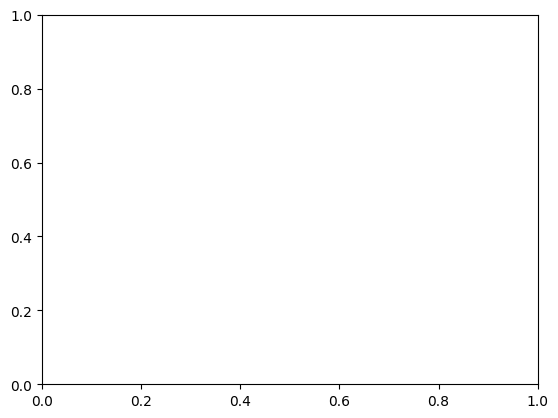

In [38]:
import matplotlib.pyplot as plt

x = test_eva * Hartree
y = test_pred_eva * Hartree

x = x[x>-50]
y = y[y>-50]
plt.scatter(x,y)

plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.show()

In [39]:
import matplotlib.pyplot as plt

x = test_mull * Hartree
y = test_pred_mull * Hartree

x = x[x>-50]
y = y[y>-50]
plt.scatter(x,y)

plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target Mulliken (eV)')
plt.ylabel('Predicted Mulliken (eV)')
plt.show()

NameError: name 'test_mull' is not defined

## Indirect learning of eigenvalues via bacprop

In [39]:
import os
os.environ["PYSCFAD_BACKEND"] = "torch"
import torch
from torch.autograd.functional import jacobian
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
from tqdm import tqdm

In [40]:
from cmath import inf
best = inf
early_stop_criteria = 50

In [41]:
# Do this only if you want to start your indirect training from the Ridge fitted weights
pred_train = model.forward(ml_data.feat_train, return_type="tensor", batch_indices=ml_data.train_idx, ridge_fit=True)

In [42]:
pred_evals, _, pred_P, _ = compute_mulliken(ml_data, pred_train, ml_data.train_idx)
targ_evals, _, targ_P, _ = compute_mulliken(ml_data, ml_data.target.tensor[ml_data.train_idx], ml_data.train_idx)

In [43]:
loss_fn(pred_evals, targ_evals), loss_fn(pred_P, targ_P)

(tensor(0.0013, grad_fn=<SumBackward0>),
 tensor(9.2786e-06, grad_fn=<SumBackward0>))

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=20, verbose=True
)

val_interval = 10
loss_fn = getattr(mlmetrics, "L2_loss") 
losses = []
losses_eval = []
losses_P = []
early_stop_count = 0
nepochs = 800

In [ ]:
iterator = tqdm(range(nepochs))

for epoch in iterator:
    model.train(True)
    train_loss = 0
    loss_eval_epoch = 0
    loss_P_epoch = 0
    for data in train_dl:
        optimizer.zero_grad()
        idx = data["idx"]

        #forward pass
        pred = model(data["input"], return_type="tensor", batch_indices=idx)
        #pred_evals = compute_eigvals(ml_data, pred, data["idx"])
        #targ_evals = compute_eigvals(ml_data, ml_data.target.tensor[idx], data["idx"])
        pred_evals, _, pred_P, _ = compute_mulliken(ml_data, pred, idx)
        targ_evals, _, targ_P, _ = compute_mulliken(ml_data, ml_data.target.tensor[idx], idx)
        
        loss_eval = loss_fn(pred_evals, targ_evals) 
        loss_P = loss_fn(pred_P, targ_P)
        loss = (3 * loss_eval + loss_P) * 1e4
        
        loss_eval_epoch += loss_eval.item()
        loss_P_epoch += loss_P.item()
        train_loss += loss.item()
        
        # backward pass
        loss.backward(retain_graph = True)
        optimizer.step()
        
    losses_eval.append(loss_eval_epoch)
    losses_P.append(loss_P_epoch)
    losses.append(train_loss)
    scheduler.step(train_loss)
    
    model.train(False)

    if epoch % val_interval == 0:
        val_loss = 0
        for i, data in enumerate(val_dl):
            idx = data["idx"]
            val_pred = model(data["input"], return_type="tensor", batch_indices=idx)
            #val_pred_eval = compute_eigvals(ml_data, pred, data["idx"])
            #val_targ_eval = compute_eigvals(ml_data, ml_data.target.tensor[idx], data["idx"])
            val_pred_eval, _, val_pred_P, _ = compute_mulliken(ml_data, val_pred, data["idx"])
            val_targ_eval, _, val_targ_P, _ = compute_mulliken(ml_data, ml_data.target.tensor[idx], data["idx"])
            vloss = 3 * loss_fn(val_pred_eval, val_targ_eval) + loss_fn(val_pred_P, val_targ_P)
            val_loss += vloss.item()
            
        new_best = val_loss < best
        if new_best:
            best = val_loss
            # torch.save(model.state_dict(), 'best_model_dipole.pt')
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

            print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")
            # Save last best model
            break

    if epoch % 1 == 0:
        iterator.set_postfix(train_loss = train_loss/len(ml_data.train_idx), 
                             Val_loss = val_loss/len(ml_data.val_idx),
                            eval_loss = loss_eval.item(), P_loss = loss_P.item())
        # print('loss_eval = ', loss_eval, 'loss_mull', loss_mull)
        

 51%|█████████████████████████████████████████████▋                                            | 406/800 [1:22:31<1:32:41, 14.12s/it, P_loss=5.89e-5, Val_loss=1.51e-5, eval_loss=3.72e-5, train_loss=0.158]

In [1]:
from matplotlib import pyplot as plt
plt.loglog(losses, label = "combined")
plt.loglog(losses_eval, label = "eva")
plt.loglog(losses_dm, label ='dm')
plt.legend()

NameError: name 'losses' is not defined

In [47]:
from IPython.utils import io

In [48]:
with io.capture_output() as captured:
    test_fock_predictions = model.forward(
        ml_data.feat_test, return_type="tensor", batch_indices=ml_data.test_idx,
    )

In [49]:
test_eva_pred_ind, test_mull_pred_ind = compute_mulliken(ml_data, test_fock_predictions, ml_data.test_idx)
test_eva_ref, test_mull_ref = compute_mulliken(ml_data, ml_data.target.tensor[ml_data.test_idx], ml_data.test_idx)

In [ ]:
error1 = loss_fn(test_eva_pred_ind, test_eva_ref) / len(ml_data.test_idx)
error1

In [51]:
print("Test RMSE on MO energies after indirect learning on eigenvalues {:.5f} eV ".format(torch.sqrt(error1/16)*Hartree))

Test RMSE on MO energies after indirect learning on eigenvalues 8.65129 eV 


In [ ]:
error2 = loss_fn(test_mull_pred_ind, test_mull_ref) / len(ml_data.test_idx)
error2

In [ ]:
print("Test RMSE on MO energies after indirect learning on Mulliken {:.5f} eV ".format(torch.sqrt(error2/16)*Hartree))

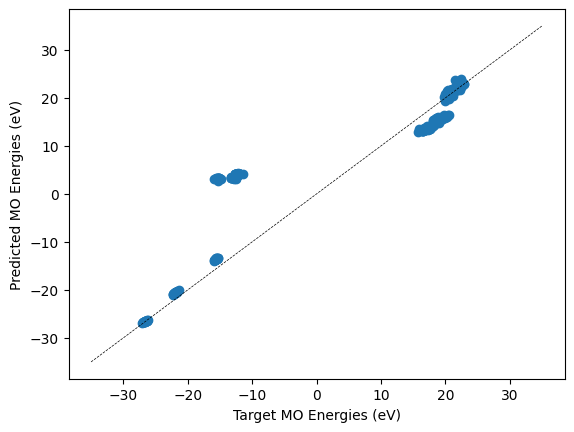

In [52]:
x = test_eva_ref.detach().numpy()  * Hartree
y = test_eva_pred_ind.detach().numpy()  * Hartree

x = x[x>-50]
y = y[y>-50]
plt.scatter(x,y)
    
plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.show()

In [54]:
loss_fn(test_mull_ref, test_mull_pred_ind)

tensor(0.3676, grad_fn=<SumBackward0>)

In [55]:
loss_fn(test_eva_ref, test_eva_pred_ind)

tensor(33.9625, grad_fn=<SumBackward0>)

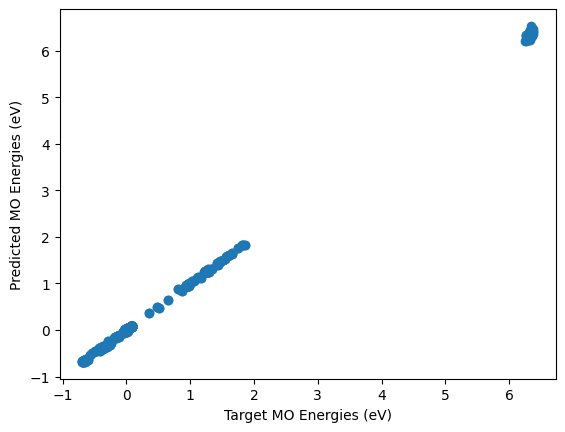

In [56]:
x = test_mull_ref.detach().numpy().flatten() # * Hartree
y = test_mull_pred_ind.detach().numpy().flatten() # * Hartree

# x = x[x>-50]
# y = y[y>-50]
plt.scatter(x,y)
    
# plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.show()